**Bank Churn Prediction**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, classification_report
from tensorflow.keras import optimizers

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


**Read the data set and EDA**

In [5]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Project - Bank Churn Prediction/bank.csv")

In [6]:
df.shape

(10000, 14)

In [7]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df[df.isna().any(axis=1)].any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [9]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

 **Drop the columns which are unique for all users like IDs**

In [10]:
for name in df.columns:
  print(df[name].nunique())

10000
10000
2932
460
3
2
70
11
6382
4
2
2
9999
2


**Will drop RowNumber, CustomerId, Surname though Surname is not unique per row, think it does not contribute value in the model**

In [11]:
dfUsed = df.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [12]:
dfUsed.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [13]:
dfUsed.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


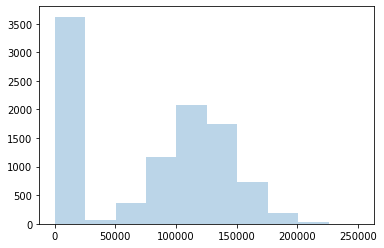

In [14]:
kwargs = dict(histtype='stepfilled', alpha=0.3,  bins=10)
plt.hist(dfUsed['Balance'],**kwargs)
plt.show()

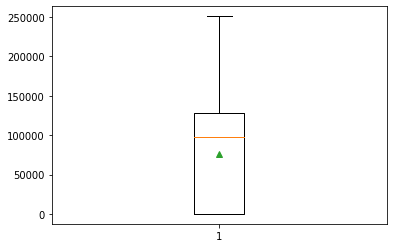

In [15]:
plt.boxplot(dfUsed['Balance'],showmeans=True)
plt.show()

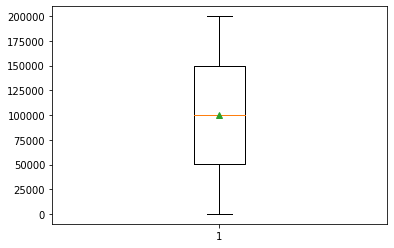

In [16]:
plt.boxplot(dfUsed['EstimatedSalary'],showmeans=True)
plt.show()

**Variable Balance has heavy left skewness, after applying hot encoding for Geography, Gender will apply sqrt transformation to it**


**One Hot Encoding for 2 categorical variables, Geography, Gender**

In [17]:
geography=pd.get_dummies(dfUsed['Geography'])
gender=pd.get_dummies(dfUsed['Gender'])

In [18]:
dfUsed = pd.concat([dfUsed,geography,gender],axis=1)
dfUsed=dfUsed.drop(['Geography','Gender'],axis=1)
dfUsed.head(1)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,619,42,2,0.0,1,1,1,101348.88,1,1,0,0,1,0


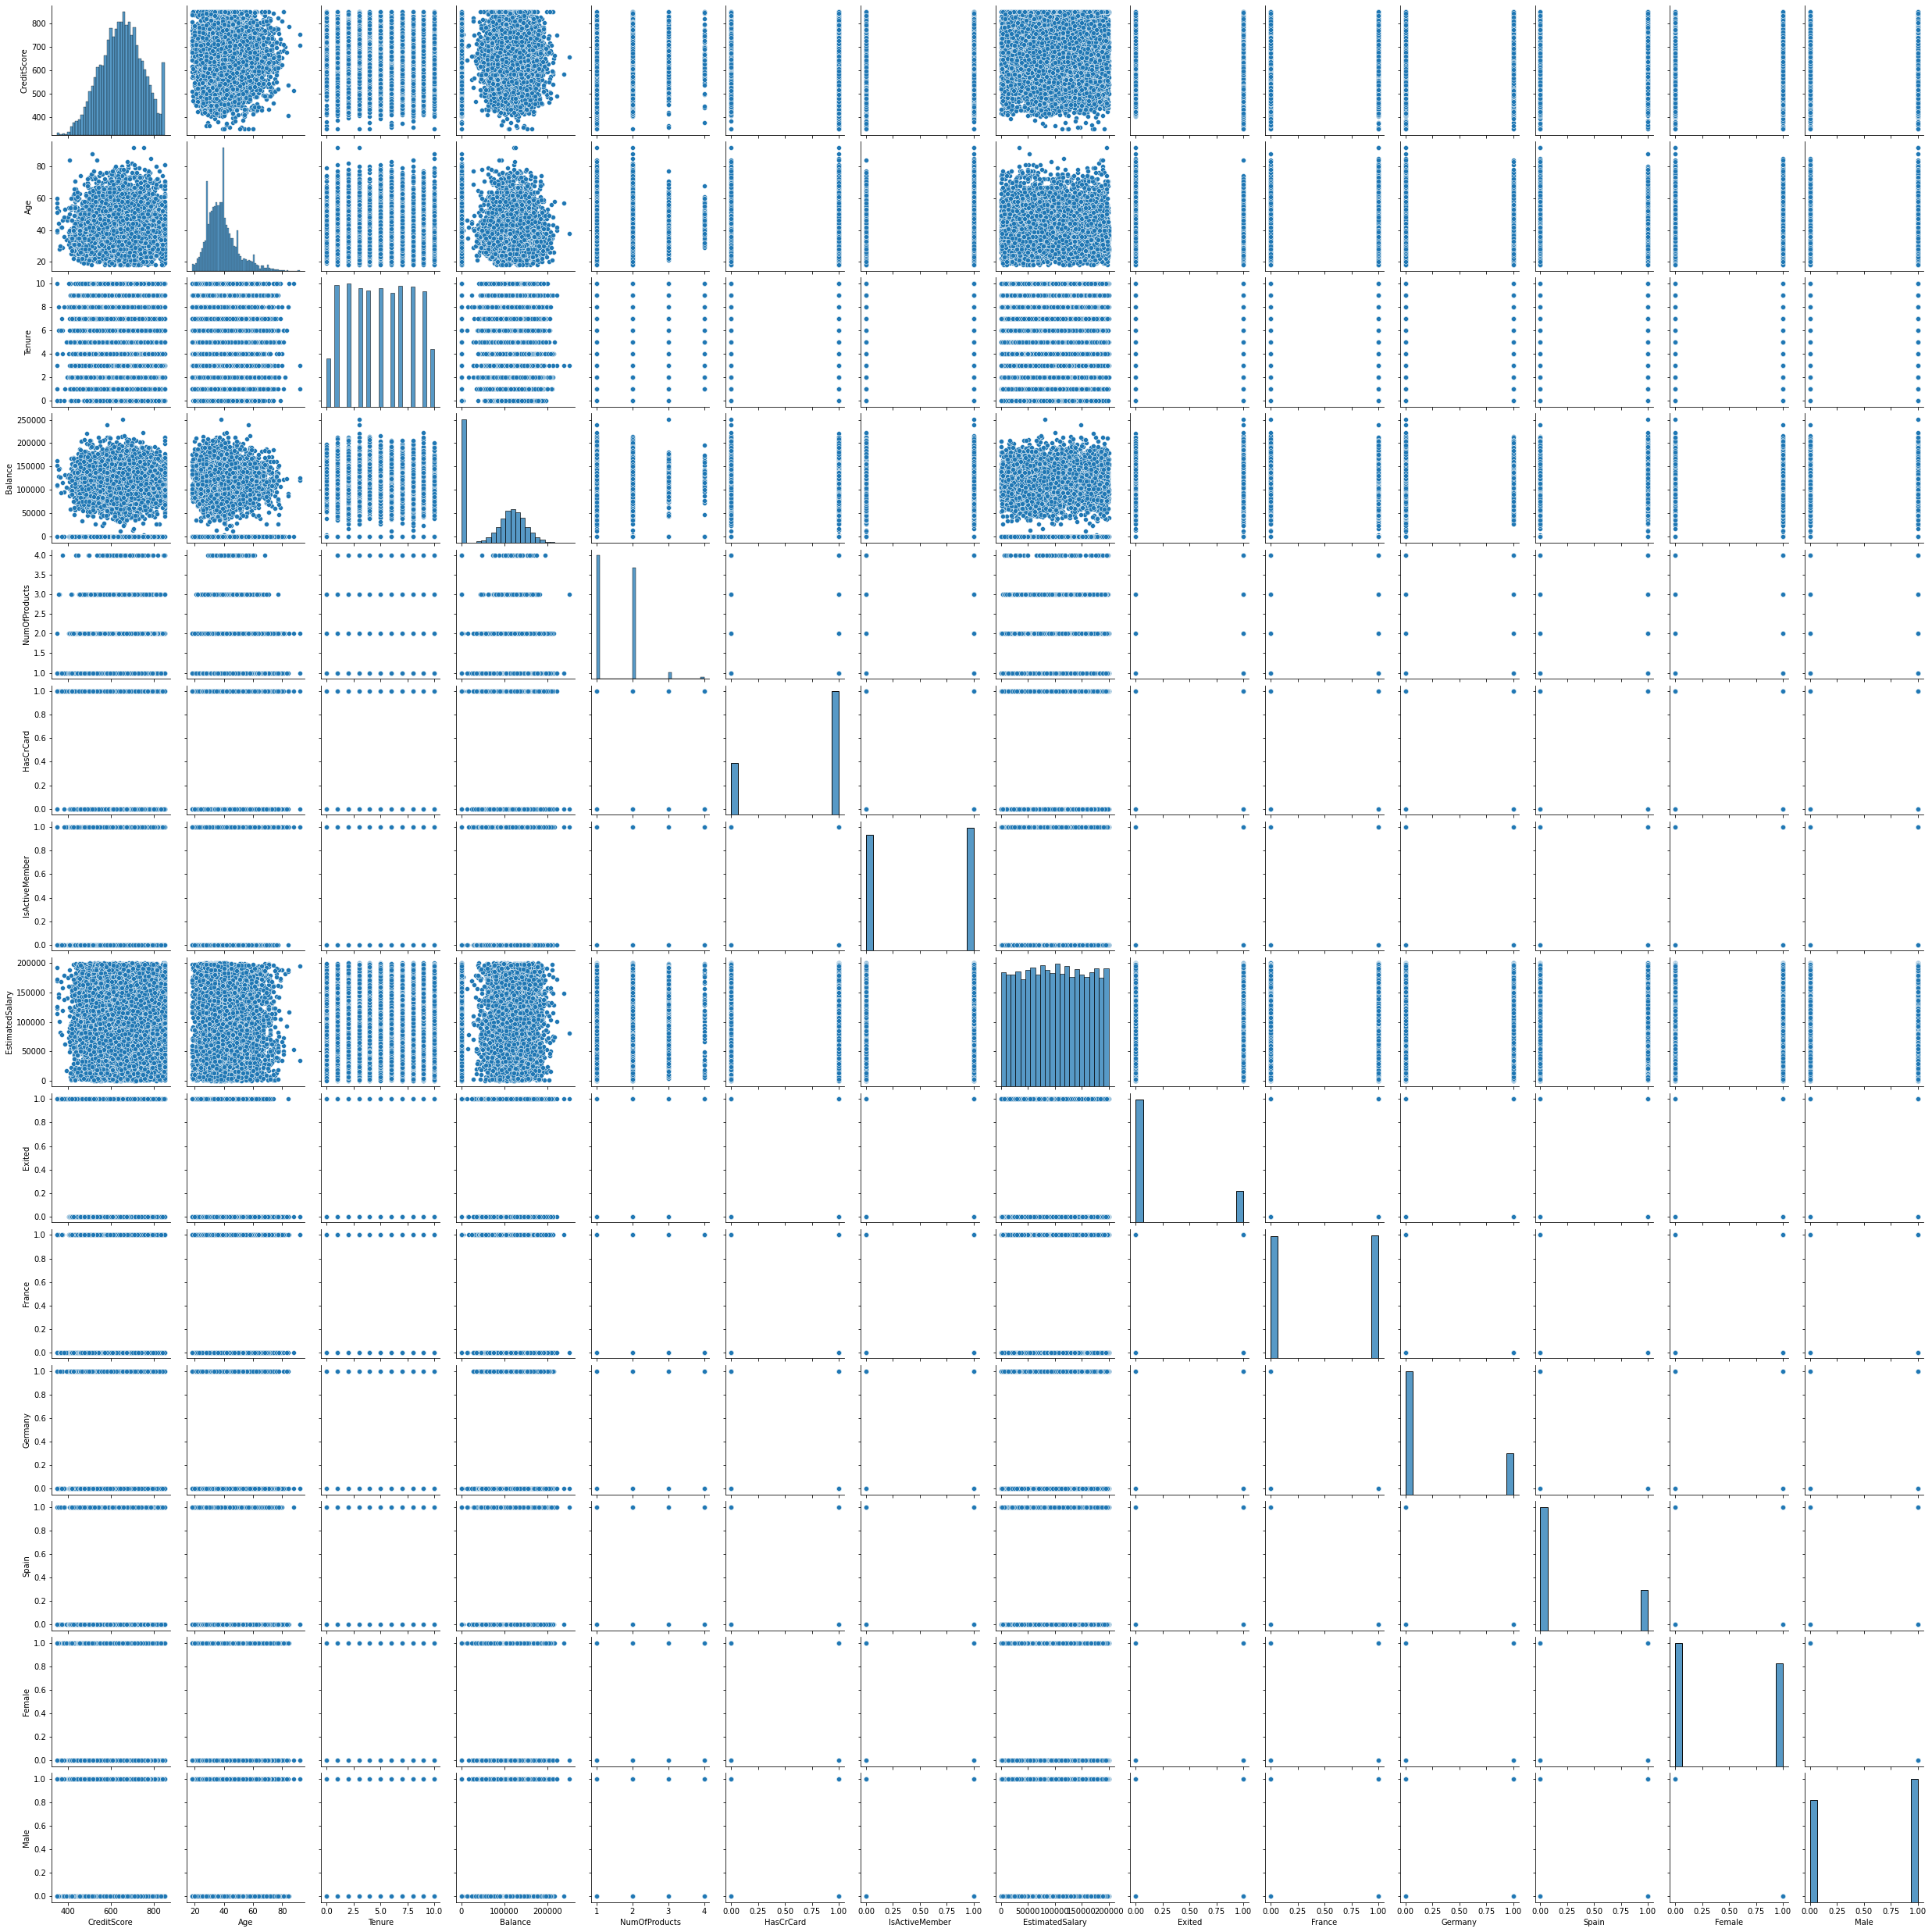

In [19]:
sns.pairplot(dfUsed)

In [20]:
dfUsed.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.008928,0.005538,0.004780,0.002857,-0.002857
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.039208,0.046897,-0.001685,0.027544,-0.027544
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.002848,-0.000567,0.003868,-0.014733,0.014733
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,-0.231329,0.401110,-0.134892,-0.012087,0.012087
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.001230,-0.010419,0.009039,0.021859,-0.021859
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.002467,0.010577,-0.013480,-0.005766,0.005766
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.003317,-0.020486,0.016732,-0.022544,0.022544
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.003332,0.010297,-0.006482,0.008112,-0.008112
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,-0.104955,0.173488,-0.052667,0.106512,-0.106512
France,-0.008928,-0.039208,-0.002848,-0.231329,0.001230,0.002467,0.003317,-0.003332,-0.104955,1.000000,-0.580359,-0.575418,-0.006772,0.006772


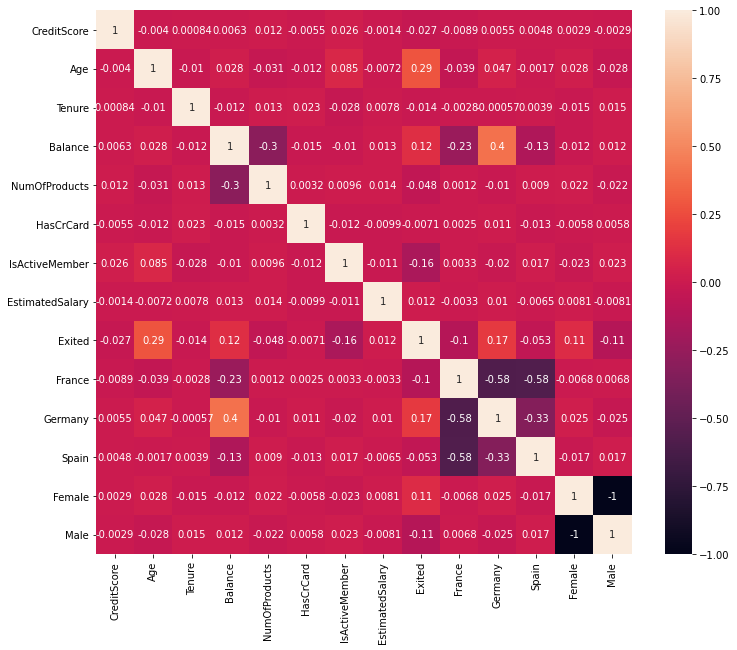

In [21]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(dfUsed.corr(), annot=True, ax=ax)

**Distinguish the features and target variable**

**Exited is target variable, rest are independent features**

In [22]:
# X - features, y - target
X = dfUsed.loc[:, dfUsed.columns != 'Exited']
y = dfUsed['Exited']

In [23]:
print(X.columns)
print(y.name)

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'France', 'Germany', 'Spain',
       'Female', 'Male'],
      dtype='object')
Exited


In [24]:
X = X.apply(lambda x: np.sqrt(x) if x.name == 'Balance' else x)
print(X['Balance'].describe())

count    10000.000000
mean       219.080430
std        168.797226
min          0.000000
25%          0.000000
50%        311.766803
75%        357.273341
max        500.897285
Name: Balance, dtype: float64


**Divide the data sets into training and test sets**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 13) (2000, 13) (8000,) (2000,)


**Scaling**



In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)


**Create model**


In [28]:
model1 = Sequential()

**Adding layers**


In [29]:
model1.add(Dense(32, input_shape = (13,), activation = 'relu'))
model1.add(Dense(16, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

**Model compile [optimizers and loss functions]**


In [30]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [31]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


**Training**


In [32]:
model1.fit(X_train, y_train, batch_size = 30, epochs = 10, verbose = 1)

Epoch 1/10
267/267 [==============================] - 1s 2ms/step - loss: 0.4690 - accuracy: 0.7912
Epoch 2/10
267/267 [==============================] - 1s 2ms/step - loss: 0.4063 - accuracy: 0.8230
Epoch 3/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3756 - accuracy: 0.8424
Epoch 4/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3578 - accuracy: 0.8524
Epoch 5/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3489 - accuracy: 0.8547
Epoch 6/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3444 - accuracy: 0.8558
Epoch 7/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3413 - accuracy: 0.8591
Epoch 8/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3394 - accuracy: 0.8611
Epoch 9/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3374 - accuracy: 0.8612
Epoch 10/10
267/267 [==============================] - 1s 2ms/step - loss: 0.3354 - accuracy: 0.8614

**Evaluation**


In [33]:
y_predict = model1.predict(X_test)

**Predict the results using 0.5 as a threshold**


In [34]:
print("Values bigger than 0.5 =", y_predict[y_predict>=0.5])
print("Their indices are ", np.nonzero(y_predict >= 0.5))

Values bigger than 0.5 = [0.8131327  0.8458374  0.6181091  0.58404315 0.6083357  0.9559947
 0.5803718  0.55426127 0.93086123 0.8357013  0.72814643 0.9215079
 0.67909676 0.8816573  0.7559702  0.8828572  0.90552384 0.6532196
 0.50869226 0.67826766 0.6348587  0.55968857 0.5014676  0.5339681
 0.8841589  0.5891227  0.5495283  0.9987531  0.8123899  0.8993768
 0.62866616 0.53653055 0.7848013  0.5464258  0.95373285 0.6672924
 0.59610194 0.7784305  0.66414255 0.601977   0.58592343 0.7035923
 0.7789185  0.77446485 0.91592246 0.556688   0.69423085 0.5060596
 0.90864944 0.5051637  0.9947241  0.8104538  0.9997123  0.96421534
 0.6660903  0.9667009  0.99855703 0.533821   0.80796885 0.63498193
 0.73939896 0.560196   0.6313703  0.6792171  0.7632967  0.74361014
 0.5640503  0.6937346  0.73741525 0.76673996 0.5048092  0.7781897
 0.7249722  0.8116751  0.662868   0.676754   0.8606387  0.6589923
 0.8820606  0.63244027 0.84491843 0.73089004 0.7519357  0.5992066
 0.9992465  0.82151395 0.9998468  0.7529134  0.9

**Print the Accuracy score and confusion matrix**


In [35]:
loss, acc = model1.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)

Accuracy: 0.859
Loss: 0.338


In [36]:
print(classification_report(y_test.astype('int'), y_predict.astype('int')))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1595
           1       0.00      0.00      0.00       405

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000



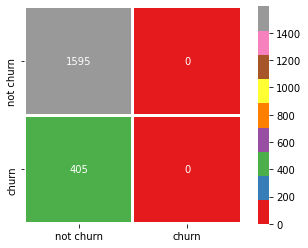

In [38]:
conf_matrix = confusion_matrix(y_test.astype('int'), y_predict.astype('int'))
sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
 xticklabels=["not churn","churn"],
 yticklabels=["not churn","churn"],
 linewidths = 2,linecolor = "w",cmap = "Set1")
plt.subplots_adjust(wspace = .3,hspace = .3)

**Try different batch and epoch size**



In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 13) (2000, 13) (8000,) (2000,)


In [40]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [41]:
model2 = Sequential()

In [42]:
model2.add(Dense(32, input_shape = (13,), activation = 'relu'))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

In [43]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [44]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                448       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [45]:
model2.fit(X_train, y_train, batch_size = 10, epochs = 30, verbose = 1)

Epoch 1/30
800/800 [==============================] - 1s 2ms/step - loss: 0.4412 - accuracy: 0.8148
Epoch 2/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3814 - accuracy: 0.8406
Epoch 3/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3551 - accuracy: 0.8547
Epoch 4/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3461 - accuracy: 0.8566
Epoch 5/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3415 - accuracy: 0.8584
Epoch 6/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3376 - accuracy: 0.8616
Epoch 7/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3357 - accuracy: 0.8601
Epoch 8/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3336 - accuracy: 0.8609
Epoch 9/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3319 - accuracy: 0.8644
Epoch 10/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3300 - accuracy: 0.8619

In [46]:
y2_predict = model2.predict(X_test)

In [47]:
print("Values bigger than 0.5 =", y2_predict[y2_predict>=0.5])
print("Their indices are ", np.nonzero(y2_predict >= 0.5))

Values bigger than 0.5 = [0.9147938  0.98659664 0.91893    0.9820209  0.90945804 0.8466343
 0.7807931  0.8817568  0.502531   0.6235792  0.9049973  0.94293135
 0.96629703 0.54762006 0.6899342  0.64583516 0.7633669  0.50903636
 0.88798887 0.8027073  0.5040399  0.99988747 0.902412   0.9556853
 0.53102416 0.9326295  0.55505776 0.6355884  0.9871874  0.72958755
 0.96008104 0.6473427  0.53827465 0.7939455  0.62524575 0.73834455
 0.95273393 0.5483158  0.67600566 0.9508531  0.9996288  0.9220607
 0.9999862  0.9790922  0.5960364  0.66261244 0.99824    0.999684
 0.78897834 0.5369086  0.6695723  0.77987105 0.55848837 0.70525825
 0.7570632  0.6266381  0.6478601  0.516415   0.57350504 0.86486775
 0.7525275  0.84209484 0.5332569  0.83474195 0.58056253 0.52255106
 0.5682855  0.68626416 0.8408337  0.628803   0.64600646 0.6889091
 0.72912955 0.834042   0.9998431  0.9530475  0.9999964  0.62148523
 0.6689105  0.99994636 0.6193609  0.9382315  0.71115303 0.6354402
 0.99999905 0.6725342  0.65736604 0.6223776 

In [48]:
loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)

Accuracy: 0.862
Loss: 0.340


In [49]:
print(classification_report(y_test.astype('int'), y2_predict.astype('int')))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1595
           1       0.00      0.00      0.00       405

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000



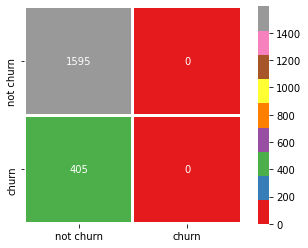

In [50]:
conf_matrix = confusion_matrix(y_test.astype('int'), y2_predict.astype('int'))
sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
 xticklabels=["not churn","churn"],
 yticklabels=["not churn","churn"],
 linewidths = 2,linecolor = "w",cmap = "Set1")
plt.subplots_adjust(wspace = .3,hspace = .3)

**Accuracy slightly improved, but more or less same metrics observed with using different batch and epoch size. Using validation set, and different classification functions may result again slight improvement**